# Clean data based on number of grasps and fixations

In [1]:
import os
import datetime

import numpy as np
import pandas as pd
import scipy

import statsmodels as sm
import statsmodels.formula.api as smf
from patsy.contrasts import ContrastMatrix
import patsy

import matplotlib.pyplot as plt
import matplotlib.pylab as mpl
import seaborn as sns

from IPython.display import display

from functools import partial

from utils.multi_processing_functions import *

PLOT_PATH = './plots_grasp_aligned_fixations_final/'
PROCESSED_DATA_PATH = '../processed_data/EIH_1/'

sns.set(
    context="talk",
    style="ticks",
    palette="muted",
    rc={'font.weight':'light'}    
)

## Read processed data file

In [3]:
samples_df = pd.read_csv(
    '../processed_data/EIH_1/05_ET_samples_graspInfo.csv',
    parse_dates = ['timestamp_dt'],
    dtype = {
        'isFixV': np.bool, 'grasp_onset_bool': np.bool,'grasp_end_bool': np.bool,
#         'subjectID': 'int32', 'trial_num': 'int32', 'trialID': 'int32',
    },
    index_col=False,
)
samples_df.head()

C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\IPython\core\interactiveshell.py:3331: DtypeWarning: Columns (31,69,70) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,timestamp_dt,combinedEye_position_x,combinedEye_position_y,combinedEye_position_z,combinedEye_direction_x,combinedEye_direction_y,combinedEye_direction_z,combinedEye_raycastHitObject,combinedEye_raycastHitLocation_x,combinedEye_raycastHitLocation_y,...,fix_stop,fix_onset_bool,fix_stop_bool,grasp_onset,grasp_stop,grasp_duration,grasp_onset_bool,grasp_end_bool,pickup_location,drop_location
0,1970-01-01 00:00:00.352107048,0.003028,-0.001079,-0.024180,-0.054200,0.050507,0.997252,Back,-0.039172,1.393820,...,1970-01-01 00:00:00.692297995,True,False,1970-01-01 00:00:00.352107048,1970-01-01 00:00:00.352107048,0.0,False,False,NaN,NaN
1,1970-01-01 00:00:00.360527635,0.003028,-0.001079,-0.024180,-0.054200,0.050507,0.997252,Back,-0.038426,1.393964,...,1970-01-01 00:00:00.692297995,False,False,1970-01-01 00:00:00.360527635,1970-01-01 00:00:00.360527635,0.0,False,False,NaN,NaN
2,1970-01-01 00:00:00.370871246,0.002949,-0.001093,-0.024174,-0.053986,0.050858,0.997246,Back,-0.037744,1.394590,...,1970-01-01 00:00:00.692297995,False,False,1970-01-01 00:00:00.370871246,1970-01-01 00:00:00.370871246,0.0,False,False,NaN,NaN
3,1970-01-01 00:00:00.381479651,0.002235,-0.001173,-0.024120,-0.053696,0.051041,0.997252,Back,-0.036357,1.395406,...,1970-01-01 00:00:00.692297995,False,False,1970-01-01 00:00:00.381479651,1970-01-01 00:00:00.381479651,0.0,False,False,NaN,NaN
4,1970-01-01 00:00:00.392510742,0.002873,-0.001116,-0.024140,-0.053543,0.051026,0.997261,Back,-0.035890,1.395458,...,1970-01-01 00:00:00.692297995,False,False,1970-01-01 00:00:00.392510742,1970-01-01 00:00:00.392510742,0.0,False,False,NaN,NaN


In [4]:
#change column names as pep8 standards

samples_df = samples_df.rename(columns = {
    'subjectID': 'subject_id',
#     'trialNum' : 'trial_num',
    'combinedEye_raycastHitObject' : 'eye_hit',
    'eye_shelfHits' : 'eye_shelf_hit',
    'trialID' : 'trial_id',
    'isFixV' : 'is_fixation',
    'nosePointer_shelfHits' : 'head_hit',
    'isOutlierFix' : 'is_outlier_fixation',
    'handData_graspedObject' : 'grasp'
    
})
print(samples_df.shape)
print(samples_df.query('eye_shelf_hit == "ERROR"').shape)

samples_df = (
    samples_df
    .query('subject_id not in [2008, 2011, 2039, 2034, 2042, 2046]')
    .query('eye_shelf_hit != "ERROR"')
    .query('subject_id != 2022 and trial_num != 0')
    .query('subject_id != 2044 and trial_num != 1')
)

samples_df.loc[
    (
        (samples_df.subject_id == 2040)
        & (samples_df.subjectfileName.str.endswith('_2.etd'))
    ), 'trial_num'
] += 3

samples_df['trial_type'] = (
    samples_df
    .trial_id
    .apply(lambda s: 'easy' if s in np.arange(0,8) else 'hard')
)

samples_df = samples_df[[
    'subject_id', 'trial_num', 'trial_type', 'timestamp_dt', 'is_fixation', 'eye_hit', 'grasp',
    'grasp_onset_bool', 'eye_shelf_hit', 'fix_duration', 'grasp_end_bool', 'grasp_duration', 
    'is_outlier_fixation', 'pickup_location', 'drop_location'
]]

valid_objs = ['Cube_Blue', 'Cube_Green', 'Cube_Red', 'Cube_Yellow',
    'Cylinder_Blue', 'Cylinder_Green', 'Cylinder_Red','Cylinder_Yellow',
    'Sphere_Blue', 'Sphere_Green', 'Sphere_Red', 'Sphere_Yellow', 
    'Tetraeder_Blue', 'Tetraeder_Green', 'Tetraeder_Red', 'Tetraeder_Yellow']

samples_df.loc[~(samples_df.eye_hit.isin(valid_objs)) & 
           ~(pd.isnull(samples_df.eye_hit)),
               'eye_hit'] ='Other'

(10153442, 71)
(0, 71)


## Get number of grasps per subject and trial

In [5]:
def get_grasps(sample_df): 
    sample_df = sample_df.sort_values(by='timestamp_dt')
    grasp_times = (
        sample_df.query('grasp_onset_bool == 1')
        [['pickup_location', 'grasp', 'timestamp_dt']]
        .rename(columns=dict(
            timestamp_dt='on_time',
            grasp='current_TO',
        ))
    )
    grasp_times['off_time'] = sample_df.query('grasp_end_bool == 1').timestamp_dt.values
    grasp_times['drop_location'] = sample_df.query('grasp_end_bool == 1').drop_location.values
    grasp_times = grasp_times.sort_values(by='on_time').reset_index(drop=True)

    grasp_times = grasp_times.drop_duplicates(subset = ['pickup_location', 'drop_location', 'current_TO'], keep='first')

    grasp_times = grasp_times.query('pickup_location != drop_location')
    grasp_times['between_grasp_duration'] = (grasp_times['on_time'].shift(-1) - grasp_times['on_time'])/np.timedelta64(1, 's')
    grasp_times['in_grasp_duration'] = (grasp_times['off_time'] - grasp_times['on_time'])/np.timedelta64(1, 's')
    
    grasp_times[['pickup_x','pickup_y']] = grasp_times.pickup_location.str.split('_', expand=True)
    grasp_times[['drop_x','drop_y']] = grasp_times.drop_location.str.split('_', expand=True)
    grasp_times['offset_x'] = grasp_times.drop_x.astype(int) - grasp_times.pickup_x.astype(int)
    grasp_times['offset_y'] = grasp_times.drop_y.astype(int) - grasp_times.pickup_y.astype(int)
    grasp_times['grasp_num'] = grasp_times.index
    
    return grasp_times.set_index('grasp_num')

grp_cols = ['subject_id', 'trial_type', 'trial_num']
grasp_df = (
    samples_df
    .reset_index()
#         .query('subject_id == @subjects')
    .groupby(grp_cols)
    .apply(get_grasps)        
)
# df.reset_index(level=2, drop=True)

display(grasp_df.head())

pickup_location       current_TO  \
subject_id trial_type trial_num grasp_num                                    
2006.0     easy       5.0       0                     2_1  Tetraeder_Green   
                                1                     2_2      Cube_Yellow   
                                2                     1_4     Sphere_Green   
                                3                     2_4  Cylinder_Yellow   
                                4                     2_5         Cube_Red   

                                                                on_time  \
subject_id trial_type trial_num grasp_num                                 
2006.0     easy       5.0       0         1970-01-01 00:00:05.835639477   
                                1         1970-01-01 00:00:07.633999825   
                                2         1970-01-01 00:00:12.176501274   
                                3         1970-01-01 00:00:15.264882088   
                                4         1970-01-01 00:00:17.475528717   

                                                               off_time  \
subject_id trial_type trial_num grasp_num                                 
2006.0     easy       5.0       0         1970-01-01 00:00:06.802226543   
                                1         1970-01-01 00:00:10.744694710   
                                2         1970-01-01 00:00:13.243731499   
                                3         1970-01-01 00:00:16.397928238   
                                4         1970-01-01 00:00:19.519012451   

                                          drop_location  \
subject_id trial_type trial_num grasp_num                 
2006.0     easy       5.0       0                   1_1   
                                1                   1_3   
                                2                   2_2   
                                3                   1_4   
                                4                   2_3   

                                           between_grasp_duration  \
subject_id trial_type trial_num grasp_num                           
2006.0     easy       5.0       0                        1.798360   
                                1                        4.542501   
                                2                        3.088381   
                                3                        2.210647   
                                4                        3.331923   

                                           in_grasp_duration pickup_x  \
subject_id trial_type trial_num grasp_num                               
2006.0     easy       5.0       0                   0.966587        2   
                                1                   3.110695        2   
                                2                   1.067230        1   
                                3                   1.133046        2   
                                4                   2.043484        2   

                                          pickup_y drop_x drop_y  offset_x  \
subject_id trial_type trial_num grasp_num                                    
2006.0     easy       5.0       0                1      1      1        -1   
                                1                2      1      3        -1   
                                2                4      2      2         1   
                                3                4      1      4        -1   
                                4                5      2      3         0   

                                           offset_y  
subject_id trial_type trial_num grasp_num            
2006.0     easy       5.0       0                 0  
                                1                 1  
                                2                -2  
                                3                 0  
                                4                -2

In [6]:
tmpdf = (
    grasp_df
    .reset_index()
    .groupby(['subject_id', 'trial_num','trial_type',], as_index=False)
    .grasp_num
    .count()
    .rename(columns = {'grasp_num':'num_grasp'})
)
tmpdf.head()

,subject_id,trial_num,trial_type,num_grasp
0,2006.0,2.0,hard,10
1,2006.0,3.0,hard,9
2,2006.0,4.0,hard,18
3,2006.0,5.0,easy,15
4,2006.0,6.0,easy,10


### Calculate upper limit of grasps based on 1.5 x IQR

In [7]:
t1 = tmpdf.query('trial_type == "easy"')
upper_limit_easy = t1.num_grasp.quantile(0.75) + 1.5*(t1.num_grasp.quantile(0.75) - t1.num_grasp.quantile(0.25))
display(upper_limit_easy)

t2 = tmpdf.query('trial_type == "hard"')
upper_limit_hard = t2.num_grasp.quantile(0.75) + 1.5*(t2.num_grasp.quantile(0.75) - t2.num_grasp.quantile(0.25))
display(upper_limit_hard)

18.0

33.5

## Reject trials with grasps > 1.5 x IQR or < 3

In [8]:
reject_subjects = pd.concat(
    [
        t1[(t1.num_grasp>upper_limit_easy) | (t1.num_grasp<3) ], 
        t2[(t2.num_grasp>upper_limit_hard) | (t2.num_grasp<3)]
    ], ignore_index=True)
#reject_subjects.to_csv('rejected_data_grasp.csv')
display(reject_subjects.head())

,subject_id,trial_num,trial_type,num_grasp
0,2012.0,15.0,easy,22
1,2012.0,20.0,easy,28
2,2014.0,13.0,easy,26
3,2015.0,2.0,easy,24
4,2016.0,10.0,easy,19


In [9]:
rejected = list(zip(reject_subjects.subject_id.values, reject_subjects.trial_num.values))

In [10]:
display(samples_df.groupby(['subject_id']).trial_num.nunique())

subject_id
2006.0    22
2007.0    22
2009.0    22
2010.0    22
2012.0    22
2013.0    22
2014.0    22
2015.0    22
2016.0    22
2017.0    22
2018.0    22
2019.0    22
2020.0    22
2021.0    22
2023.0    22
2024.0    22
2025.0    22
2026.0    22
2027.0    22
2028.0    22
2029.0    22
2030.0    22
2031.0    22
2032.0    22
2033.0    22
2035.0    22
2037.0    22
2038.0    22
2040.0    22
2041.0    22
2043.0    22
2045.0    22
2047.0    22
2048.0    22
2049.0    22
2050.0    22
2051.0    22
2052.0    22
2053.0    22
2054.0    22
2055.0    22
2056.0    22
2057.0    22
2058.0    22
2059.0    22
2060.0    22
2061.0    22
2062.0    20
Name: trial_num, dtype: int64

In [11]:
samples_df = samples_df[~samples_df[['subject_id','trial_num']].apply(tuple, 1).isin(rejected)]

In [12]:
tmpdf = samples_df.groupby(['subject_id']).trial_num.nunique().reset_index()

display(tmpdf.subject_id.nunique())
display(tmpdf.trial_num.sum())
display(tmpdf.trial_num.mean())
display(tmpdf.trial_num.std())

48

996

20.75

1.8042503010769237

In [13]:
grasp_df = grasp_df.reset_index()
grasp_df = grasp_df[~grasp_df[['subject_id','trial_num']].apply(tuple, 1).isin(rejected)]

In [14]:
tmpdf = grasp_df.groupby(['subject_id', 'trial_num']).grasp_num.nunique().reset_index()
display(tmpdf.subject_id.nunique())
display(tmpdf.grasp_num.sum())
display(tmpdf.grasp_num.mean())
display(tmpdf.grasp_num.std())

48

12266

12.315261044176706

5.110144412018798

count    996.000000
mean       1.886501
std        0.610689
min        0.902087
25%        1.515966
50%        1.773623
75%        2.116870
max        7.765473
Name: in_grasp_duration, dtype: float64

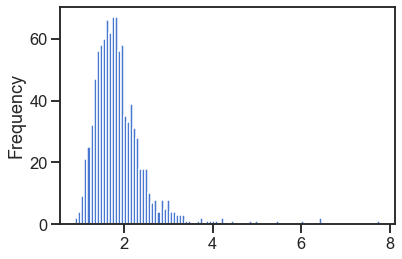

In [19]:
(
    grasp_df
    .groupby(['subject_id', 'trial_num'])
    .in_grasp_duration
    .mean()
    .reset_index()
    .in_grasp_duration
    .plot.hist(bins=100)
);

display(
    grasp_df
    .groupby(['subject_id', 'trial_num'])
    .in_grasp_duration
    .mean()
    .reset_index()
    .in_grasp_duration
    .describe()
)

count    996.000000
mean       4.637985
std        2.516168
min        1.566797
25%        3.111104
50%        3.958096
75%        5.340170
max       27.308301
Name: between_grasp_duration, dtype: float64

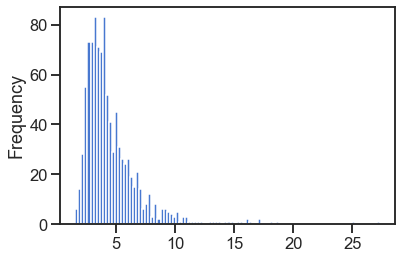

In [20]:
(
    grasp_df
    .groupby(['subject_id', 'trial_num'])
    .between_grasp_duration
    .mean()
    .reset_index()
    .between_grasp_duration
    .plot.hist(bins=100)
);

display(
    grasp_df
    .groupby(['subject_id', 'trial_num'])
    .between_grasp_duration
    .mean()
    .reset_index()
    .between_grasp_duration
    .describe()
)

In [12]:
samples_df.head()

,timestamp_dt,combinedEye_position_x,combinedEye_position_y,combinedEye_position_z,combinedEye_direction_x,combinedEye_direction_y,combinedEye_direction_z,eye_hit,combinedEye_raycastHitLocation_x,combinedEye_raycastHitLocation_y,...,fix_onset_bool,fix_stop_bool,grasp_onset,grasp_stop,grasp_duration,grasp_onset_bool,grasp_end_bool,pickup_location,drop_location,trial_type
8905,1970-01-01 00:00:00.351460844,-0.009295,-0.002215,-0.023014,0.038575,0.107453,0.993462,Other,0.227122,1.447578,...,True,False,1970-01-01 00:00:00.351460844,1970-01-01 00:00:00.351460844,0.0,False,False,NaN,NaN,hard
8906,1970-01-01 00:00:00.360775739,-0.004848,-0.001775,-0.023124,0.037461,0.100694,0.994212,Other,0.225640,1.438154,...,False,False,1970-01-01 00:00:00.360775739,1970-01-01 00:00:00.360775739,0.0,False,False,NaN,NaN,hard
8907,1970-01-01 00:00:00.371934354,-0.004848,-0.001775,-0.023124,0.037461,0.100694,0.994212,Other,0.224285,1.438936,...,False,False,1970-01-01 00:00:00.371934354,1970-01-01 00:00:00.371934354,0.0,False,False,NaN,NaN,hard
8908,1970-01-01 00:00:00.383572042,-0.009973,-0.002281,-0.022997,0.037522,0.107240,0.993525,Other,0.222477,1.448279,...,False,False,1970-01-01 00:00:00.383572042,1970-01-01 00:00:00.383572042,0.0,False,False,NaN,NaN,hard
8909,1970-01-01 00:00:00.394215554,0.004572,-0.000881,-0.023263,0.042648,0.104645,0.993595,Other,0.228530,1.445886,...,False,False,1970-01-01 00:00:00.394215554,1970-01-01 00:00:00.394215554,0.0,False,False,NaN,NaN,hard


## Clean fixation samples

In [15]:
### make saccadic samples less that 0.03s into fixations
samples_df.loc[
    (samples_df.is_fixation==False) & (samples_df.fix_duration<=0.03), 
    'is_fixation'] = True

### make fixation samples less than 0.05s into saccades
samples_df.loc[
    (samples_df.is_fixation==True) & (samples_df.fix_duration<=0.05), 
    'is_fixation'] = False

### recalculate fixation duration
samples_df['fix_duration'] = (
    samples_df
    .set_index('timestamp_dt')
    .groupby(['subject_id', 'trial_num'], as_index=False)
    .is_fixation
    .apply(
        lambda x: 
        x
        .groupby((x != x.shift()).cumsum())
        .transform(lambda x: (x.index[-1] - x.index[0])/np.timedelta64(1, 's') )
    )
).reset_index().is_fixation

### discard fixation samples with duration less than 0.1s
samples_df.loc[(samples_df.is_fixation==True) & (samples_df.fix_duration<=0.1), 'is_fixation'] = False

In [16]:
def simple_mad(angular_vel, thresh = 3.5):
#     th_1 = np.median(angular_vel)
    if len(angular_vel.shape) == 1:
        angular_vel = angular_vel[:,None]
    median = np.median(angular_vel)
    diff = (angular_vel - median)**2
    diff = np.sqrt(diff)
#     print(diff)
    med_abs_deviation = np.median(diff)
    saccade_thresh = median + thresh*1.48*med_abs_deviation
    return saccade_thresh

duration_mad = simple_mad(
    samples_df
    .dropna(subset=['fix_duration'])
    .query('is_fixation==True')
    .fix_duration
)

## Only keep fixation samples that are 3.5 times the MAD
samples_df.loc[(samples_df.is_fixation == True) 
               & (samples_df.fix_duration>=duration_mad), 'is_fixation'] = False

C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


## Save cleaned data

In [15]:
samples_df.to_csv(f'{PROCESSED_DATA_PATH}/06_ET_cleaned.csv',index=False)